In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)
print(pd.__version__)

In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [3]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        if( df is not None):
            if(df.shape[0]>5000000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["Q2*","gen_Q2","y*","HFS*",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["Q2*","y*","e_*","HFS*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('logQ2_e= log(Q2_e)/2.3025850', inplace=True)
    temp.eval('logQ2_esigma= log(Q2_esigma)/2.3025850', inplace=True)
    temp.eval('logQ2_sigma= log(Q2_sigma)/2.3025850', inplace=True)
    temp.eval('logQ2_da= log(Q2_da)/2.3025850', inplace=True)

    temp.eval('s = 4*27.6*920', inplace=True)
    temp.eval('x_e = Q2_e/(s*y_e)',inplace=True)
    temp.eval('x_da = Q2_da/(s*y_da)',inplace=True)
    temp.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
    temp.eval('x_esigma = x_sigma',inplace=True)


    temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    #temp = applyCut(temp, 'pass_reco==0 | 0.08 < y_e < 0.7', '0.08 < y_e < 0.7')
    #temp = applyCut(temp, 'pass_reco==0 | Q2_e>150', 'Q2_e>150')
    temp = applyCut(temp, 'pass_reco==0 | Empz<65', 'Empz<65')
    temp = applyCut(temp, 'pass_reco==0 | Empz>45', 'Empz>45')
   
    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')
        temp = applyCut(temp,'gen_Q2>150',' gen_Q2>150')
        temp.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        
        temp.eval('yda_ratio = y_da/gen_y',inplace=True)
        temp.eval('ysigma_ratio = y_sigma/gen_y',inplace=True)
        temp.eval('yesigma_ratio = y_esigma/gen_y',inplace=True)
        temp.eval('ye_ratio = y_e/gen_y',inplace=True)
        
        temp.eval('Q2e_ratio = Q2_e/gen_Q2',inplace=True)
        temp.eval('Q2da_ratio = Q2_da/gen_Q2',inplace=True)
        temp.eval('Q2sigma_ratio = Q2_sigma/gen_Q2',inplace=True)
        temp.eval('Q2esigma_ratio = Q2_esigma/gen_Q2',inplace=True)
        
        temp.eval('xe_ratio = x_e/gen_x',inplace=True)
        temp.eval('xda_ratio = x_da/gen_x',inplace=True)
        temp.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
        temp.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        
        

    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

In [111]:
mc_name = 'Django'
altmc_name = 'Rapgap'
path ='/data0/bpnachman/forDNN_withE/out_ep0607/'
mc_tag = 'nominal'

In [112]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /data0/bpnachman/forDNN_withE/out_ep0607/Django_Eplus0607_149.nominal.root
[b'Django;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Django_Eplus0607_4.nominal.root
[b'Django;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Django_Eplus0607_2.nominal.root
[b'Django;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Django_Eplus0607_145.nominal.root
[b'Django;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Django_Eplus0607_16.nominal.root
[b'Django;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Django_Eplus0607_146.nominal.root
[b'Django;1']
####################################################################
Dataframe has a total of  5967720  entries
####################################################################
CPU times: user 5.64 s, sys: 669 ms, total: 6.31 s
Wall time: 6.34 s


In [113]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)

filename is /data0/bpnachman/forDNN_withE/out_ep0607/Rapgap_Eplus0607_5.nominal.root
[b'Rapgap;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Rapgap_Eplus0607_129.nominal.root
[b'Rapgap;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Rapgap_Eplus0607_140.nominal.root
[b'Rapgap;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Rapgap_Eplus0607_121.nominal.root
[b'Rapgap;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Rapgap_Eplus0607_143.nominal.root
[b'Rapgap;1']
filename is /data0/bpnachman/forDNN_withE/out_ep0607/Rapgap_Eplus0607_146.nominal.root
[b'Rapgap;1']
####################################################################
Dataframe has a total of  5958989  entries
####################################################################
CPU times: user 5.54 s, sys: 505 ms, total: 6.04 s
Wall time: 6.04 s


In [114]:
mc.keys()

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'Q2_h', 'gen_Q2', 'y_e',
       'y_sigma', 'y_esigma', 'y_da', 'y_h', 'HFS_px', 'HFS_py', 'HFS_pz',
       'HFS_E', 'HFS_eta', 'gen_y', 'e_px', 'e_py', 'e_pz', 'e_eta', 'gene_px',
       'gene_py', 'gene_pz', 'gene_eta', 'wgt', 'vertex_z', 'ptmiss',
       'ptratio_da', 'ptratio_ele', 'Empz', 'pth'],
      dtype='object')

In [116]:
%%time 
mc['pass_reco'] = np.where(mc['Q2_e']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['Q2_e']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['gen_Q2']>0, 1, 0)


CPU times: user 183 ms, sys: 5.07 ms, total: 188 ms
Wall time: 112 ms


In [117]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

Selecting MC events

ptmiss<10 5938791  fraction kept: 99.5
Empz<65 5938791  fraction kept: 100.0
Empz>45 5938791  fraction kept: 100.0
 pass_truth>0 5938791  fraction kept: 100.0
 gen_Q2>150 2847767  fraction kept: 48.0
Selecting MC events

ptmiss<10 5937572  fraction kept: 99.6
Empz<65 5937572  fraction kept: 100.0
Empz>45 5937572  fraction kept: 100.0
 pass_truth>0 5937572  fraction kept: 100.0
 gen_Q2>150 3038602  fraction kept: 51.2
CPU times: user 7.62 s, sys: 3.23 s, total: 10.9 s
Wall time: 8.35 s


In [12]:
mc.keys()

#Empz, HFS_px', 'HFS_py', 'HFS_pz', e_px','e_py', 'e_pz

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'gen_Q2', 'y_e', 'y_sigma',
       'y_esigma', 'y_da', 'HFS_px', 'HFS_py', 'HFS_pz', 'gen_y', 'e_px',
       'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt', 'vertex_z',
       'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth', 'pass_reco',
       'pass_truth', 'e_pt', 'e_phi', 'logQ2_e', 'logQ2_esigma', 'logQ2_sigma',
       'logQ2_da', 's', 'x_e', 'x_da', 'x_sigma', 'x_esigma', 'gen_x',
       'gen_logQ2', 'gene_pt', 'yda_ratio', 'ysigma_ratio', 'yesigma_ratio',
       'ye_ratio', 'Q2e_ratio', 'Q2da_ratio', 'Q2sigma_ratio',
       'Q2esigma_ratio', 'xe_ratio', 'xda_ratio', 'xsigma_ratio',
       'xesigma_ratio'],
      dtype='object')

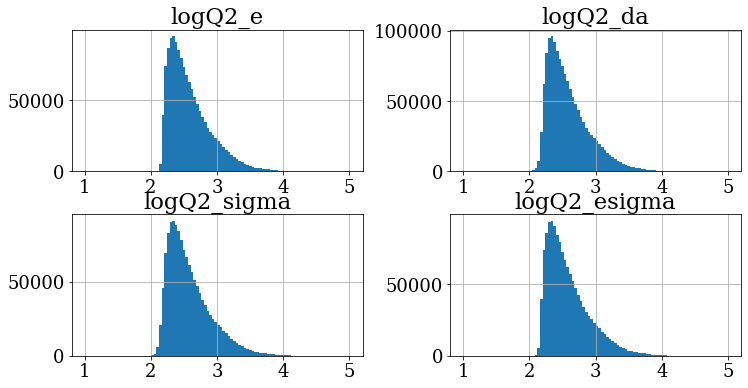

In [13]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['logQ2_e','logQ2_da','logQ2_sigma','logQ2_esigma'],range=(1,5))
plt.show()

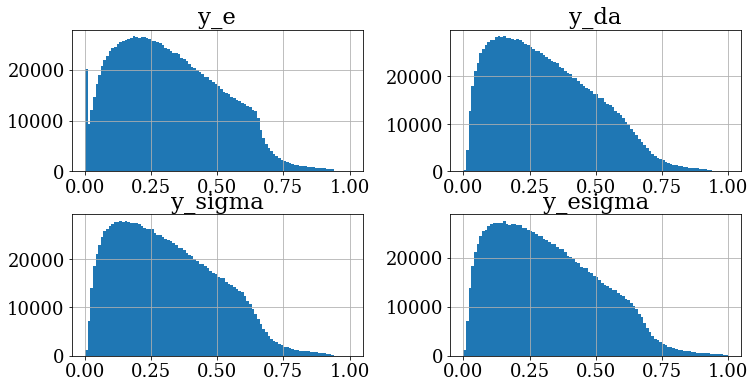

In [14]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['y_e','y_da','y_sigma','y_esigma'],range=(0,1))
plt.show()

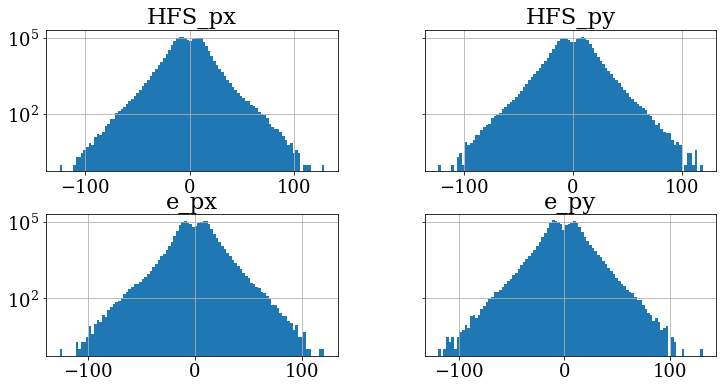

In [15]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_px','HFS_py','e_px','e_py'],sharey=True)
plt.yscale('log')

plt.show()

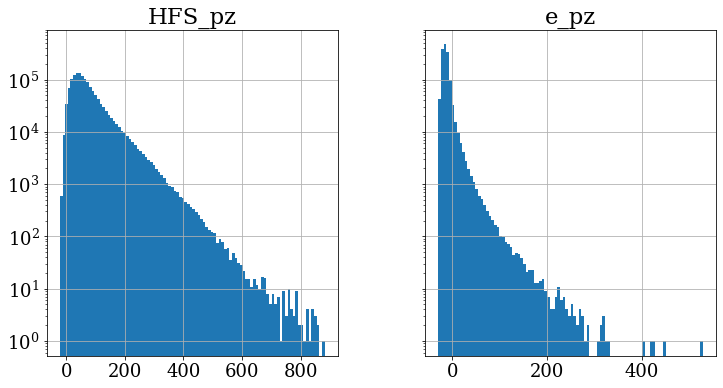

In [16]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_pz','e_pz'],sharey=True)
plt.yscale('log')
plt.show()

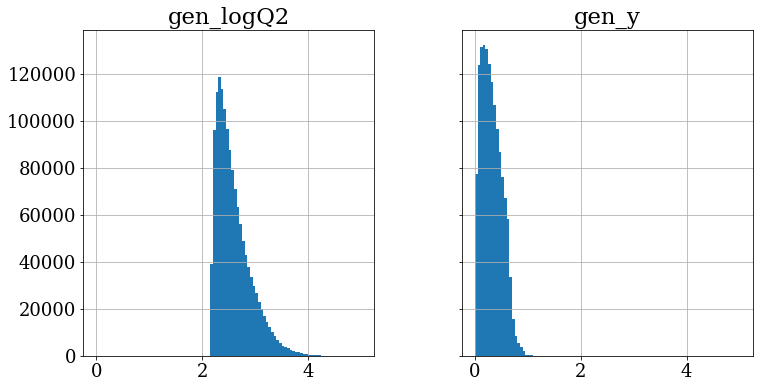

In [17]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['gen_logQ2','gen_y'],range=(0,5),sharey=True)
plt.show()

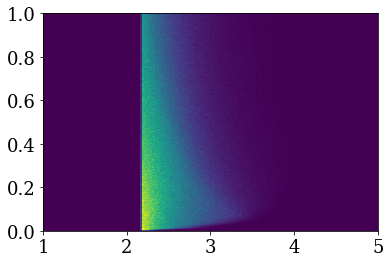

In [18]:
plt.hist2d(mc['gen_logQ2'],mc['gen_y'],range=([1,5],[0,1]),bins=200)
plt.show()

In [19]:
mc.eval('yda_ratio = y_da/gen_y',inplace=True)
mc.eval('ysigma_ratio = y_sigma/gen_y',inplace=True)
mc.eval('yesigma_ratio = y_esigma/gen_y',inplace=True)
mc.eval('ye_ratio = y_e/gen_y',inplace=True)


mc.eval('Q2da_ratio = Q2_da/gen_Q2',inplace=True)
mc.eval('Q2sigma_ratio = Q2_sigma/gen_Q2',inplace=True)
mc.eval('Q2esigma_ratio = Q2_esigma/gen_Q2',inplace=True)

mc.eval('Q2e_ratio = Q2_e/gen_Q2',inplace=True)


['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


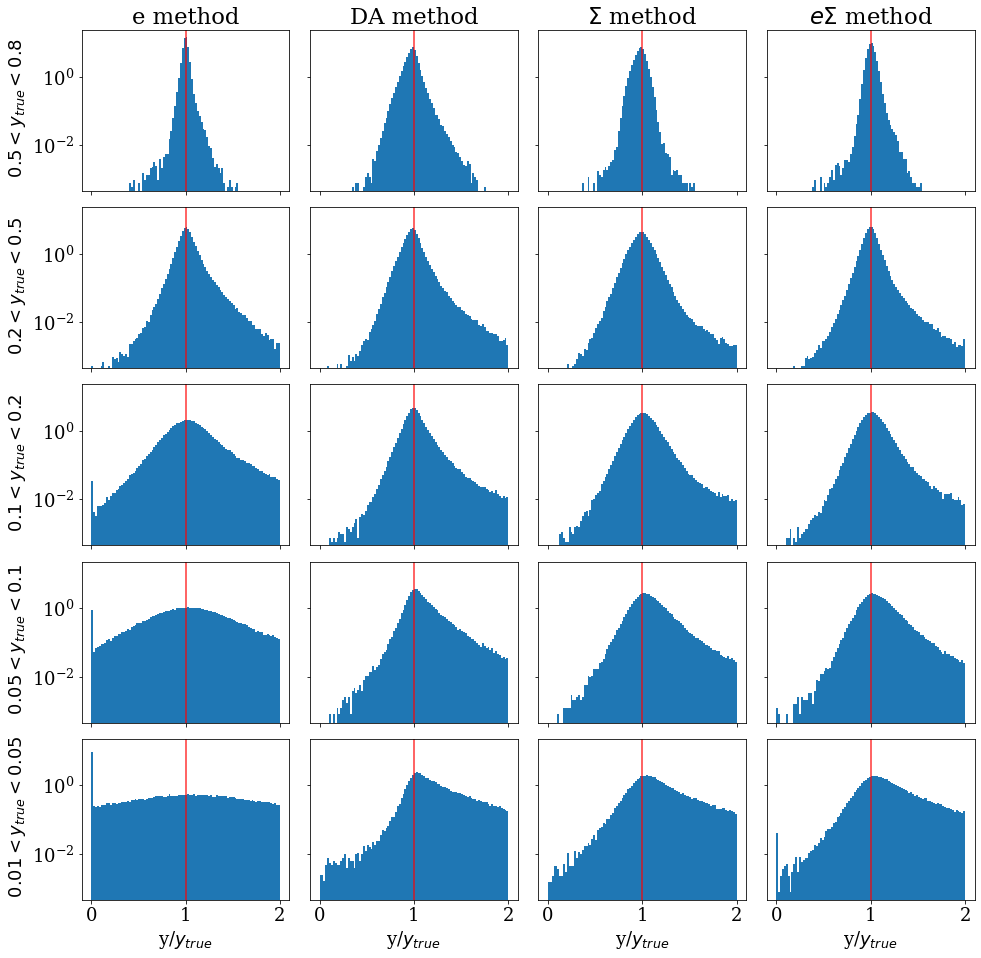

In [20]:
fig,ax = plt.subplots(5,4,figsize=(16,16),sharey=True,sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['ye_ratio'],density=True,bins=100,range=(0,2),label='e method')
    ax[1 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['yda_ratio'],density=True,bins=100,range=(0,2),label='DA method')
    ax[2 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['ysigma_ratio'],density=True,bins=100,range=(0,2),label='$\Sigma$ method')
    ax[3 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['yesigma_ratio'],density=True,bins=100,range=(0,2),label='$e-\Sigma$ method')

for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('e method')
ax[1].set_title('DA method')
ax[2].set_title('$\Sigma$ method')
ax[3].set_title('$e\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'y/$y_{true}$ ')

ax[-2].set_xlabel(r'y/$y_{true}$ ')
ax[-3].set_xlabel(r'y/$y_{true}$ ')
ax[-4].set_xlabel(r'y/$y_{true}$ ')


plt.show()

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


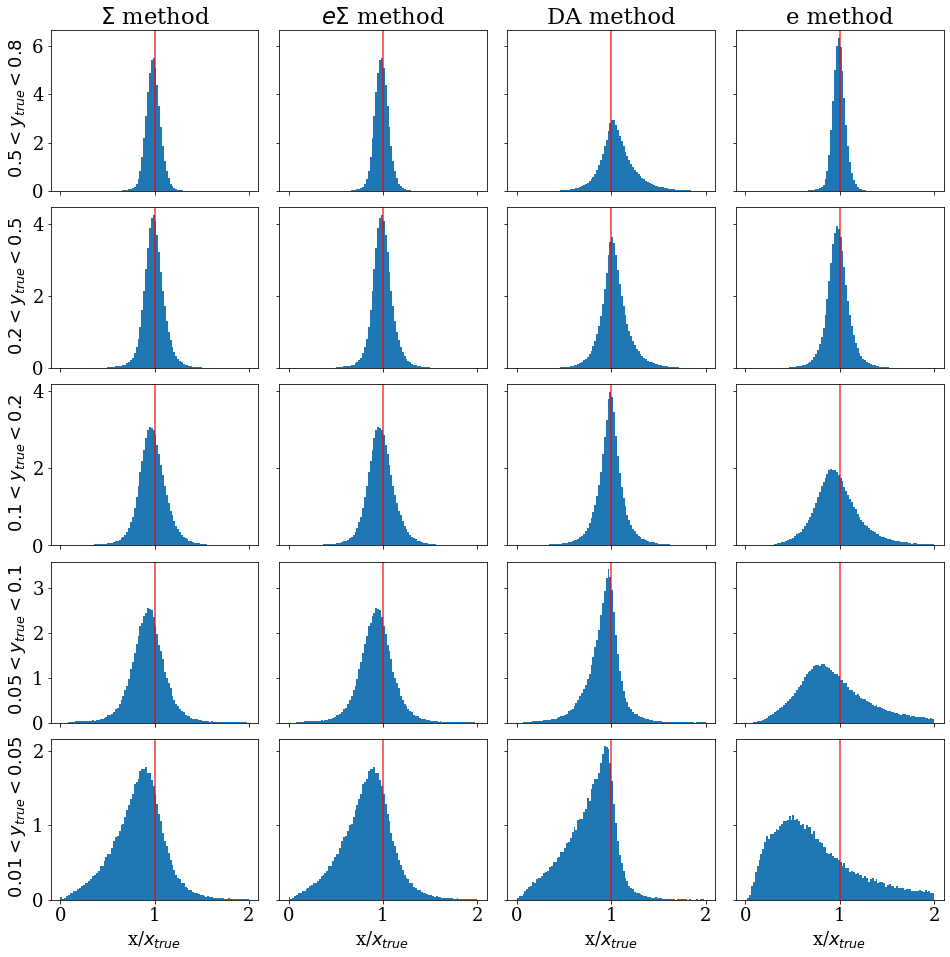

In [21]:
fig,ax = plt.subplots(5,4,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0,2))

for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

## Machine Learning begins

First, let's just combine all four methods into one.  Then, we can add more information.

In [22]:
mc.keys()

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'gen_Q2', 'y_e', 'y_sigma',
       'y_esigma', 'y_da', 'HFS_px', 'HFS_py', 'HFS_pz', 'gen_y', 'e_px',
       'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt', 'vertex_z',
       'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth', 'pass_reco',
       'pass_truth', 'e_pt', 'e_phi', 'logQ2_e', 'logQ2_esigma', 'logQ2_sigma',
       'logQ2_da', 's', 'x_e', 'x_da', 'x_sigma', 'x_esigma', 'gen_x',
       'gen_logQ2', 'gene_pt', 'yda_ratio', 'ysigma_ratio', 'yesigma_ratio',
       'ye_ratio', 'Q2e_ratio', 'Q2da_ratio', 'Q2sigma_ratio',
       'Q2esigma_ratio', 'xe_ratio', 'xda_ratio', 'xsigma_ratio',
       'xesigma_ratio'],
      dtype='object')

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
os.environ['CUDA_VISIBLE_DEVICES']="0"

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [24]:
model = Sequential()
model.add(Dense(64, input_dim=8*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [25]:
plt.hist(X[:,0],bins=np.logspace(-3,2,20))
plt.yscale("log")
plt.xscale("log")

NameError: name 'X' is not defined

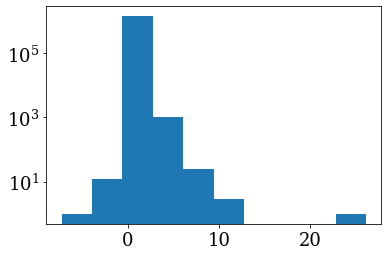

In [26]:
plt.hist(np.log(mc['x_da'])/np.log(mc['gen_x']))
plt.yscale("log")

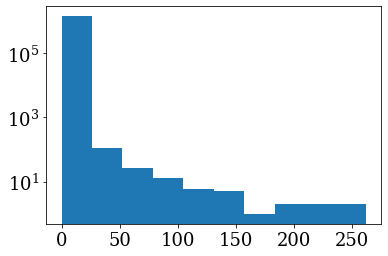

In [27]:
plt.hist(mc['gen_x']/mc['x_da'])
plt.yscale("log")

(array([2.70279e+06, 1.03978e+05, 2.98360e+04, 8.55300e+03, 2.12500e+03,
        4.11000e+02, 6.30000e+01, 1.00000e+01, 0.00000e+00, 1.00000e+00]),
 array([0.        , 0.12038165, 0.2407633 , 0.36114495, 0.4815266 ,
        0.60190825, 0.72228991, 0.84267156, 0.96305321, 1.08343486,
        1.20381651]),
 <BarContainer object of 10 artists>)

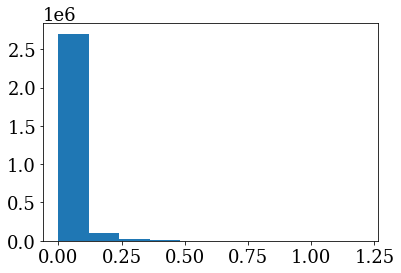

In [28]:
plt.hist(np.nan_to_num(mc['gen_x'].to_numpy(),posinf=0,neginf=0))

(array([2.70279e+06, 1.03978e+05, 2.98360e+04, 8.55300e+03, 2.12500e+03,
        4.11000e+02, 6.30000e+01, 1.00000e+01, 0.00000e+00, 1.00000e+00]),
 array([0.        , 0.12038165, 0.2407633 , 0.36114495, 0.4815266 ,
        0.60190825, 0.72228991, 0.84267156, 0.96305321, 1.08343486,
        1.20381651]),
 <BarContainer object of 10 artists>)

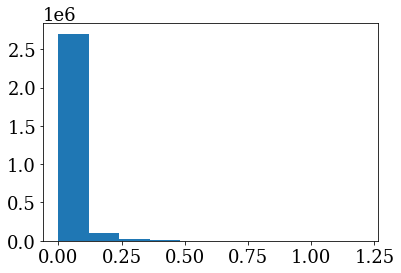

In [29]:
plt.hist(np.nan_to_num(mc['gen_x'].to_numpy(),posinf=0,neginf=0))

(array([2.847756e+06, 4.000000e+00, 2.000000e+00, 3.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([ 0.        ,  2.43399089,  4.86798177,  7.30197266,  9.73596354,
        12.16995443, 14.60394532, 17.0379362 , 19.47192709, 21.90591797,
        24.33990886]),
 <BarContainer object of 10 artists>)

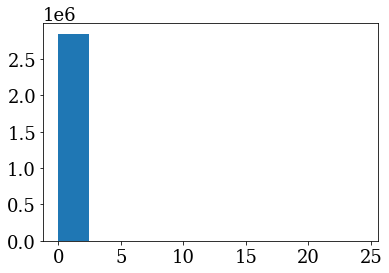

In [30]:
plt.hist(np.nan_to_num(mc['x_sigma'].to_numpy(),posinf=0,neginf=0))

In [31]:
plt.hist(Y,bins=np.linspace(-5,15,40),alpha=0.5)
plt.hist(Y2,bins=np.linspace(-5,15,40),alpha=0.5)
plt.yscale("log")

NameError: name 'Y' is not defined

In [32]:
plt.hist(X[:,0]-X[:,1])

NameError: name 'X' is not defined

In [33]:
eps = 1e-1
X = np.c_[mc['x_sigma'].to_numpy(),mc['x_esigma'].to_numpy(),mc['x_da'].to_numpy(),mc['x_e'].to_numpy(),
         mc['y_sigma'].to_numpy(),mc['y_esigma'].to_numpy(),mc['y_da'].to_numpy(),mc['y_e'].to_numpy(),
         np.log(mc['x_sigma'].to_numpy()),np.log(mc['x_esigma'].to_numpy()),np.log(mc['x_da'].to_numpy()),np.log(mc['x_e'].to_numpy()),
         np.log(mc['y_sigma'].to_numpy()),np.log(mc['y_esigma'].to_numpy()),np.log(mc['y_da'].to_numpy()),np.log(mc['y_e'].to_numpy())]
pass_reco = mc['pass_reco']
pass_true = mc['pass_truth']
X = X[(pass_reco==1)*(pass_true==1)]
X = np.nan_to_num(X,posinf=0,neginf=0)

Y = mc['gen_x'].to_numpy()
Y = Y[(pass_reco==1)*(pass_true==1)]

#den = np.median([X[:,0],X[:,1],X[:,2],X[:,3]],axis=0)
#Y = Y/den
#Y = np.nan_to_num(Y,posinf=0,neginf=0)

GY = mc['gen_y'].to_numpy()
GY = GY[(pass_reco==1)*(pass_true==1)]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1, 1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

<ipython-input-33-a8d4d3c6f946>:4: RuntimeWarning: divide by zero encountered in log
  np.log(mc['x_sigma'].to_numpy()),np.log(mc['x_esigma'].to_numpy()),np.log(mc['x_da'].to_numpy()),np.log(mc['x_e'].to_numpy()),
<ipython-input-33-a8d4d3c6f946>:5: RuntimeWarning: divide by zero encountered in log
  np.log(mc['y_sigma'].to_numpy()),np.log(mc['y_esigma'].to_numpy()),np.log(mc['y_da'].to_numpy()),np.log(mc['y_e'].to_numpy())]
<ipython-input-33-a8d4d3c6f946>:5: RuntimeWarning: invalid value encountered in log
  np.log(mc['y_sigma'].to_numpy()),np.log(mc['y_esigma'].to_numpy()),np.log(mc['y_da'].to_numpy()),np.log(mc['y_e'].to_numpy())]
/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204:

(array([ 11443.,  17249.,  28253.,  52215., 142758., 865549., 113559.,
         44506.,  22363.,  13028.,   8155.,   5875.,   4317.,   3275.,
          2670.,   2074.,   1707.,   1501.,   1233.]),
 array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
        0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
        1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
        2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ]),
 <BarContainer object of 19 artists>)

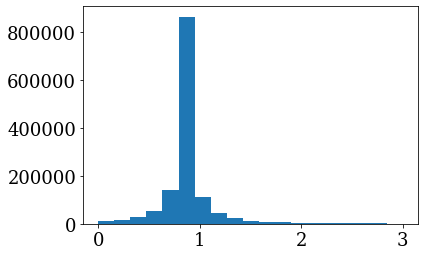

In [34]:
plt.hist(X[:,0]/Y[:,0],bins=np.linspace(0,3,20))

In [35]:
X_train, X_test, Y_train, Y_test,GY_train,GY_test = train_test_split(X,Y,GY, test_size=0.5)

In [36]:
hist = model.fit(X_train, Y_train, epochs=20, batch_size=500, verbose=1, validation_data=(X_test,Y_test))  

Epoch 1/20
1397/1397 [==============================] - 8s 5ms/step - loss: 0.3263 - accuracy: 0.0000e+00 - val_loss: 0.1245 - val_accuracy: 0.0000e+00
Epoch 2/20
1397/1397 [==============================] - 7s 5ms/step - loss: 0.2022 - accuracy: 0.0000e+00 - val_loss: 0.0743 - val_accuracy: 0.0000e+00
Epoch 3/20
1397/1397 [==============================] - 7s 5ms/step - loss: 0.1559 - accuracy: 0.0000e+00 - val_loss: 0.0537 - val_accuracy: 0.0000e+00
Epoch 4/20
1397/1397 [==============================] - 7s 5ms/step - loss: 0.1303 - accuracy: 0.0000e+00 - val_loss: 0.0448 - val_accuracy: 0.0000e+00
Epoch 5/20
1397/1397 [==============================] - 7s 5ms/step - loss: 0.1128 - accuracy: 0.0000e+00 - val_loss: 0.0402 - val_accuracy: 0.0000e+00
Epoch 6/20
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0995 - accuracy: 0.0000e+00 - val_loss: 0.0376 - val_accuracy: 0.0000e+00
Epoch 7/20
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0891 - acc

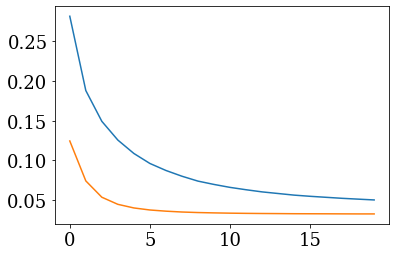

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [38]:
mypreds = model.predict(X_test,batch_size=1000)

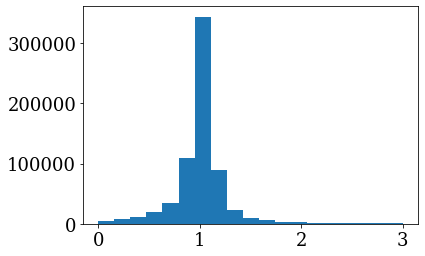

In [39]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,20))

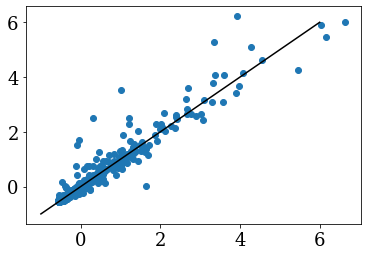

In [40]:
plt.scatter(mypreds[:,0][0:1000],Y_test[:,0][0:1000])
plt.plot([-1,6],[-1,6],color="black")

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


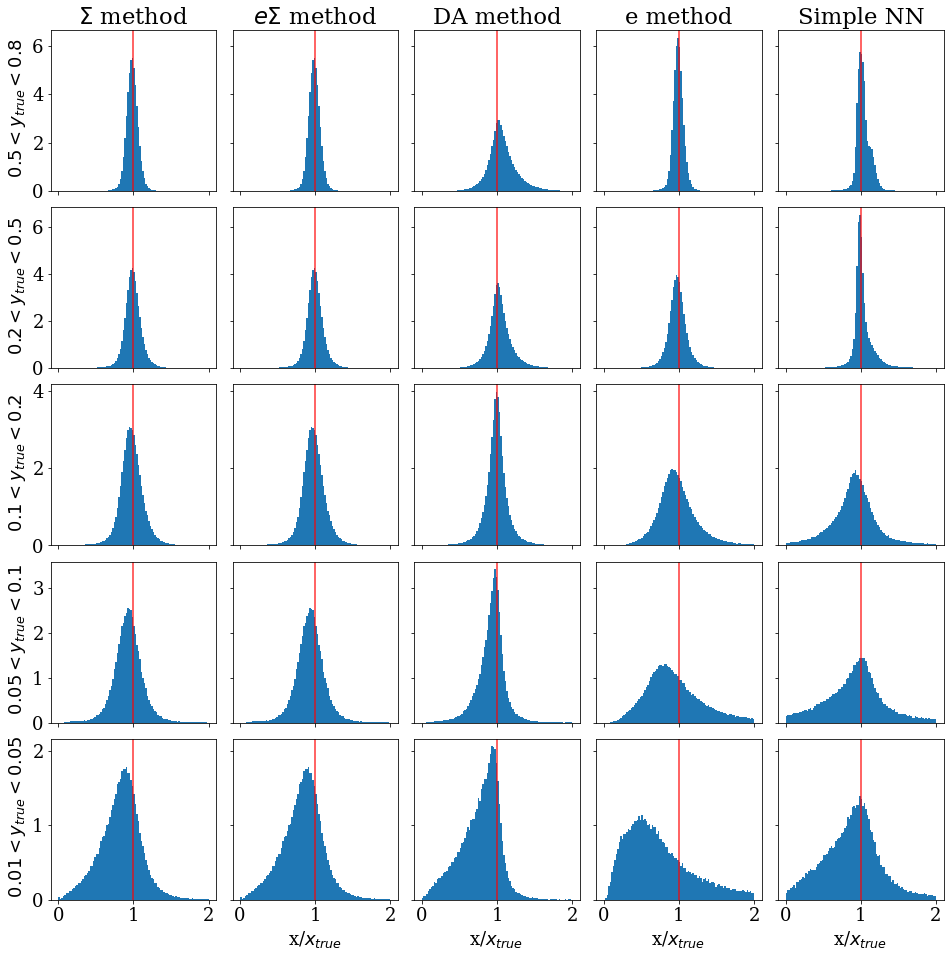

In [41]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0,2))

ax[4].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[9].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[14].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[19].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[24].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

In [42]:
mc.keys()

#Empz, HFS_px', 'HFS_py', 'HFS_pz', e_px','e_py', 'e_pz

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'gen_Q2', 'y_e', 'y_sigma',
       'y_esigma', 'y_da', 'HFS_px', 'HFS_py', 'HFS_pz', 'gen_y', 'e_px',
       'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt', 'vertex_z',
       'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth', 'pass_reco',
       'pass_truth', 'e_pt', 'e_phi', 'logQ2_e', 'logQ2_esigma', 'logQ2_sigma',
       'logQ2_da', 's', 'x_e', 'x_da', 'x_sigma', 'x_esigma', 'gen_x',
       'gen_logQ2', 'gene_pt', 'yda_ratio', 'ysigma_ratio', 'yesigma_ratio',
       'ye_ratio', 'Q2e_ratio', 'Q2da_ratio', 'Q2sigma_ratio',
       'Q2esigma_ratio', 'xe_ratio', 'xda_ratio', 'xsigma_ratio',
       'xesigma_ratio'],
      dtype='object')

In [165]:
xx = []
yy = []
for wevent in range(500000): #len(mc['HFS_E'].to_numpy())):
    Sigma = mc['HFS_E'].to_numpy()[wevent] - mc['HFS_pz'].to_numpy()[wevent]
    E = np.sqrt(mc['e_px'].to_numpy()[wevent]**2+mc['e_py'].to_numpy()[wevent]**2+mc['e_pz'].to_numpy()[wevent]**2)
    theta = np.arccos(mc['e_pz'].to_numpy()[wevent]/E)
    y = Sigma / (Sigma + E*(1.-np.cos(theta)))
    Q2 = E**2*np.sin(theta)**2/(1-y)
    s = 2*np.sqrt(920*27.5)
    s = s**2
    x = Q2/(y*s)
    if (np.isnan(x)):
        continue
    #if (x < 0):
    #    print(x,mc['x_sigma'].to_numpy()[wevent],Sigma,E,theta,y,Q2,s)
    yy+=[x]
    xx+=[mc['x_sigma'].to_numpy()[wevent]]

<ipython-input-165-a128fabeca79>:6: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(mc['e_pz'].to_numpy()[wevent]/E)


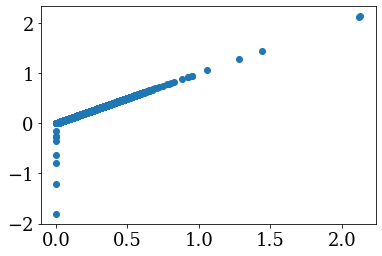

In [166]:
plt.scatter(xx,yy)

In [168]:
xx = np.array(xx)
yy = np.array(yy)

Text(0.5, 0, 'my x - H1 x')

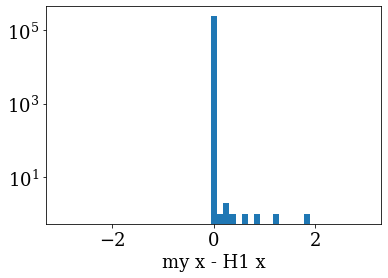

In [176]:
plt.hist(xx-yy,bins=np.linspace(-3,3,50))
plt.yscale("log")
plt.xlabel("my x - H1 x")

In [177]:
eps = 1e-1

####
Sigma = mc['HFS_E'].to_numpy() - mc['HFS_pz'].to_numpy()
T = np.sqrt(mc['HFS_px'].to_numpy()**2+mc['HFS_py'].to_numpy()**2)
E = np.sqrt(mc['e_px'].to_numpy()**2+mc['e_py'].to_numpy()**2+mc['e_pz'].to_numpy()**2)
theta = np.arccos(mc['e_pz'].to_numpy()/E)
y = Sigma / (Sigma + E*(1.-np.cos(theta)))
Q2 = E**2*np.sin(theta)**2/(1-y)
####

X = np.c_[mc['HFS_px'].to_numpy(),mc['HFS_py'].to_numpy(),mc['HFS_pz'].to_numpy(),mc['HFS_E'].to_numpy(),mc['e_px'].to_numpy(),
         mc['e_py'].to_numpy(),mc['e_pz'].to_numpy(),mc['Empz'].to_numpy(),Sigma,T,E,theta,y,Q2]
pass_reco = mc['pass_reco']
pass_true = mc['pass_truth']
X = X[(pass_reco==1)*(pass_true==1)]
X = np.nan_to_num(X,posinf=0,neginf=0)

Y = mc['gen_x'].to_numpy()
Y = Y[(pass_reco==1)*(pass_true==1)]

GY = mc['gen_y'].to_numpy()
GY = GY[(pass_reco==1)*(pass_true==1)]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1, 1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

x_sigma = mc['x_sigma'].to_numpy()
x_sigma = x_sigma[(pass_reco==1)*(pass_true==1)]

<ipython-input-177-21a2f8cb7a7b>:7: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(mc['e_pz'].to_numpy()/E)
/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/computation/expressions.py:2

In [178]:
X_train, X_test, Y_train, Y_test,GY_train,GY_test, x_sigma_train, x_sigma_test = train_test_split(X,Y,GY,x_sigma, test_size=0.5)

In [49]:
model2 = Sequential()
model2.add(Dense(64, input_dim=7, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='selu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='selu'))
model2.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
myloss = tf.keras.losses.Huber()

model2.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [63]:
hist = model2.fit(X_train, Y_train, epochs=30, batch_size=500, verbose=1, validation_data=(X_test,Y_test))  

Epoch 1/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0432 - accuracy: 0.0000e+00 - val_loss: 0.0375 - val_accuracy: 0.0000e+00
Epoch 2/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0431 - accuracy: 0.0000e+00 - val_loss: 0.0377 - val_accuracy: 0.0000e+00
Epoch 3/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0429 - accuracy: 0.0000e+00 - val_loss: 0.0380 - val_accuracy: 0.0000e+00
Epoch 4/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0430 - accuracy: 0.0000e+00 - val_loss: 0.0365 - val_accuracy: 0.0000e+00
Epoch 5/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0431 - accuracy: 0.0000e+00 - val_loss: 0.0374 - val_accuracy: 0.0000e+00
Epoch 6/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0431 - accuracy: 0.0000e+00 - val_loss: 0.0377 - val_accuracy: 0.0000e+00
Epoch 7/30
1397/1397 [==============================] - 7s 5ms/step - loss: 0.0429 - acc

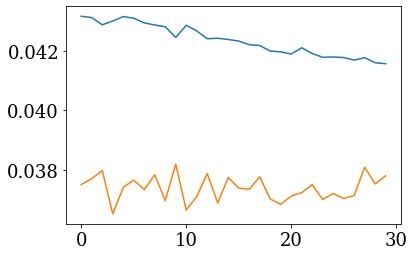

In [64]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [65]:
mypreds2 = model2.predict(X_test,batch_size=1000)

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


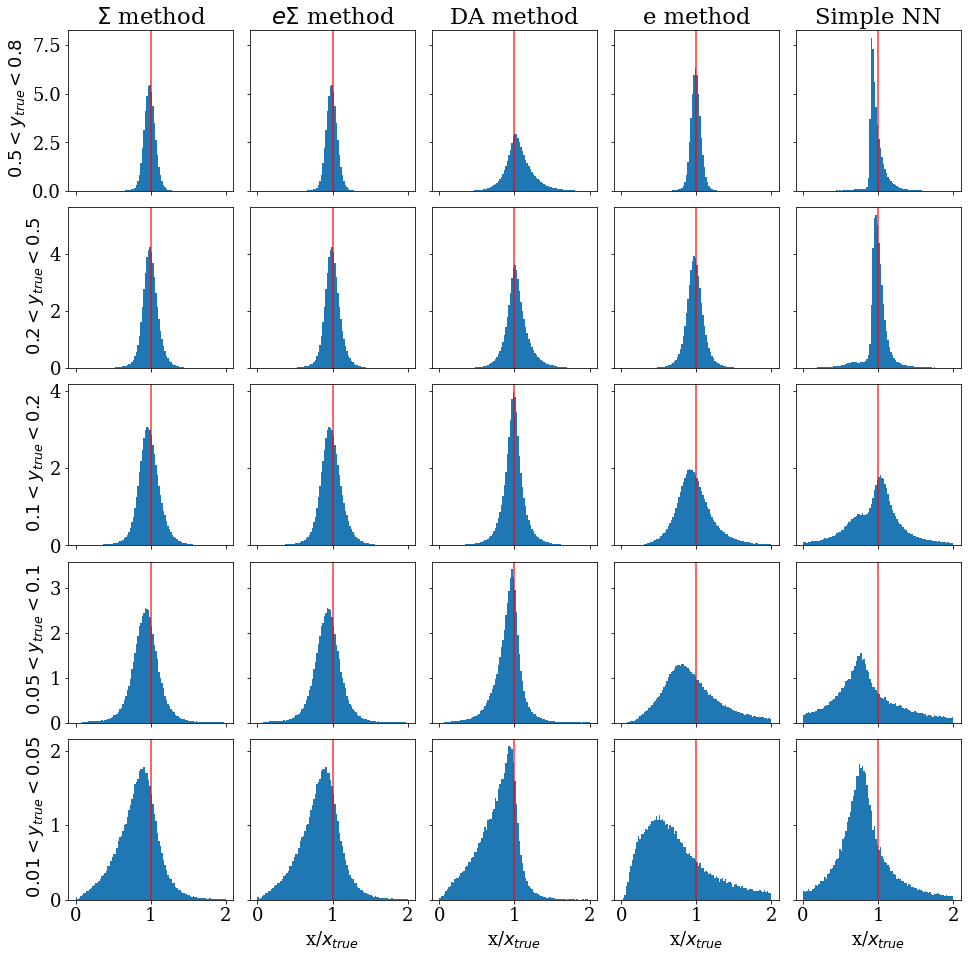

In [66]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0,2))

ax[4].hist(mypreds2[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[9].hist(mypreds2[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[14].hist(mypreds2[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[19].hist(mypreds2[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[24].hist(mypreds2[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

(array([41762., 65893., 69212., 69442., 67565., 64651., 59617., 53934.,
        48279., 42744., 37621., 32997., 22776., 10085.,  4964.,  3032.,
         1970.,  1068.,   223.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

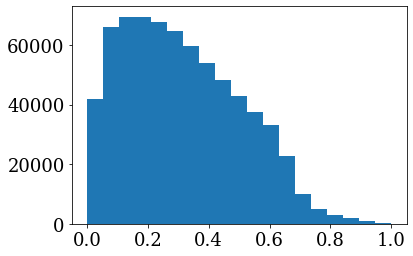

In [68]:
plt.hist(GY_test,bins=np.linspace(0,1,20))

In [70]:
model3 = Sequential()
model3.add(Dense(64, input_dim=7, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='selu'))
model3.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
myloss = tf.keras.losses.Huber()

model3.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [90]:
hist3 = model3.fit(X_train[GY_train<0.1], Y_train[GY_train<0.1], epochs=100, batch_size=500, verbose=1, validation_data=(X_test[GY_test<0.1],Y_test[GY_test<0.1]))  

Epoch 1/100
201/201 [==============================] - 1s 6ms/step - loss: 0.2032 - accuracy: 0.0000e+00 - val_loss: 0.1738 - val_accuracy: 0.0000e+00
Epoch 2/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2030 - accuracy: 0.0000e+00 - val_loss: 0.1737 - val_accuracy: 0.0000e+00
Epoch 3/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2030 - accuracy: 0.0000e+00 - val_loss: 0.1736 - val_accuracy: 0.0000e+00
Epoch 4/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2032 - accuracy: 0.0000e+00 - val_loss: 0.1736 - val_accuracy: 0.0000e+00
Epoch 5/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2016 - accuracy: 0.0000e+00 - val_loss: 0.1729 - val_accuracy: 0.0000e+00
Epoch 6/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2033 - accuracy: 0.0000e+00 - val_loss: 0.1733 - val_accuracy: 0.0000e+00
Epoch 7/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2028 - accuracy: 

Epoch 55/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2002 - accuracy: 0.0000e+00 - val_loss: 0.1727 - val_accuracy: 0.0000e+00
Epoch 56/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2003 - accuracy: 0.0000e+00 - val_loss: 0.1720 - val_accuracy: 0.0000e+00
Epoch 57/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2009 - accuracy: 0.0000e+00 - val_loss: 0.1713 - val_accuracy: 0.0000e+00
Epoch 58/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2003 - accuracy: 0.0000e+00 - val_loss: 0.1710 - val_accuracy: 0.0000e+00
Epoch 59/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2003 - accuracy: 0.0000e+00 - val_loss: 0.1723 - val_accuracy: 0.0000e+00
Epoch 60/100
201/201 [==============================] - 1s 5ms/step - loss: 0.2004 - accuracy: 0.0000e+00 - val_loss: 0.1716 - val_accuracy: 0.0000e+00
Epoch 61/100
201/201 [==============================] - 1s 5ms/step - loss: 0.1990 - acc

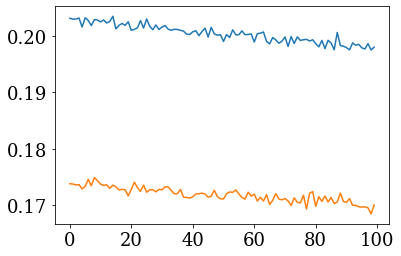

In [91]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

In [92]:
mypreds3 = model3.predict(X_test,batch_size=1000)

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


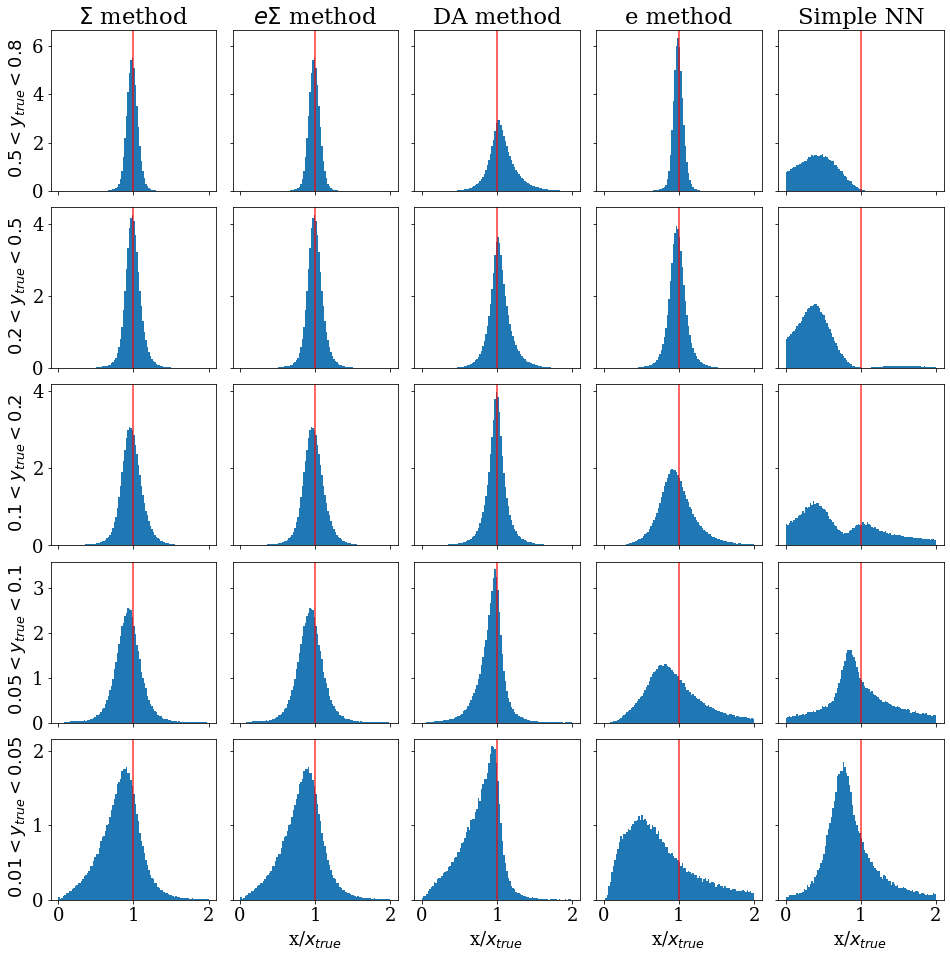

In [93]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0,2))

ax[4].hist(mypreds3[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[9].hist(mypreds3[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[14].hist(mypreds3[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[19].hist(mypreds3[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[24].hist(mypreds3[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

In [188]:
from tensorflow.keras.layers import BatchNormalization

In [189]:
model4 = Sequential()
model4.add(Dense(64, input_dim=14, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(128, activation='selu'))
model4.add(BatchNormalization())
model4.add(Dense(64, activation='selu'))
model4.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
myloss = tf.keras.losses.Huber()

model4.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [196]:
#Try to learn the reco values

hist4 = model4.fit(X_train, x_sigma_train, epochs=100, batch_size=500, verbose=1, validation_data=(X_test,x_sigma_test))  

Epoch 1/100
1397/1397 [==============================] - 9s 6ms/step - loss: 2.1865e-04 - accuracy: 3.7224e-05 - val_loss: 1.9092e-04 - val_accuracy: 4.5814e-05
Epoch 2/100
1397/1397 [==============================] - 9s 6ms/step - loss: 2.1713e-04 - accuracy: 3.7224e-05 - val_loss: 1.8725e-04 - val_accuracy: 4.5814e-05
Epoch 3/100
1397/1397 [==============================] - 9s 6ms/step - loss: 2.1430e-04 - accuracy: 3.7224e-05 - val_loss: 1.9073e-04 - val_accuracy: 4.5814e-05
Epoch 4/100
1397/1397 [==============================] - 9s 6ms/step - loss: 2.1250e-04 - accuracy: 3.7224e-05 - val_loss: 1.8682e-04 - val_accuracy: 4.5814e-05
Epoch 5/100
1397/1397 [==============================] - 9s 6ms/step - loss: 2.1228e-04 - accuracy: 3.7224e-05 - val_loss: 1.8736e-04 - val_accuracy: 4.5814e-05
Epoch 6/100
1397/1397 [==============================] - 9s 6ms/step - loss: 2.1128e-04 - accuracy: 3.7224e-05 - val_loss: 1.8689e-04 - val_accuracy: 4.5814e-05
Epoch 7/100
1397/1397 [===========

1397/1397 [==============================] - 10s 7ms/step - loss: 1.6316e-04 - accuracy: 3.7224e-05 - val_loss: 1.4277e-04 - val_accuracy: 4.5814e-05
Epoch 52/100
1397/1397 [==============================] - 10s 7ms/step - loss: 1.6277e-04 - accuracy: 3.7224e-05 - val_loss: 1.4448e-04 - val_accuracy: 4.5814e-05
Epoch 53/100
1397/1397 [==============================] - 9s 7ms/step - loss: 1.6213e-04 - accuracy: 3.7224e-05 - val_loss: 1.4222e-04 - val_accuracy: 4.5814e-05
Epoch 54/100
1397/1397 [==============================] - 10s 7ms/step - loss: 1.6055e-04 - accuracy: 3.7224e-05 - val_loss: 1.4284e-04 - val_accuracy: 4.5814e-05
Epoch 55/100
1397/1397 [==============================] - 9s 7ms/step - loss: 1.5964e-04 - accuracy: 3.7224e-05 - val_loss: 1.4052e-04 - val_accuracy: 4.5814e-05
Epoch 56/100
1397/1397 [==============================] - 9s 7ms/step - loss: 1.6040e-04 - accuracy: 3.7224e-05 - val_loss: 1.4557e-04 - val_accuracy: 4.5814e-05
Epoch 57/100
1397/1397 [==============

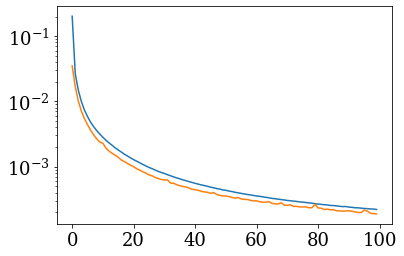

In [191]:
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.yscale("log")

In [192]:
mypreds4 = model4.predict(X_test,batch_size=1000)

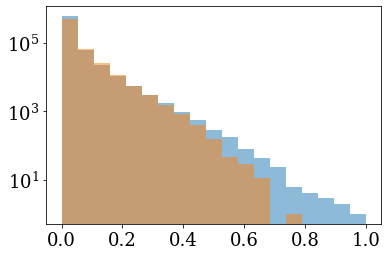

In [193]:
plt.hist(x_sigma_test,bins=np.linspace(0,1,20),alpha=0.5)
plt.hist(mypreds4,bins=np.linspace(0,1,20),alpha=0.5)
plt.yscale("log")

(0.0, 1.0)

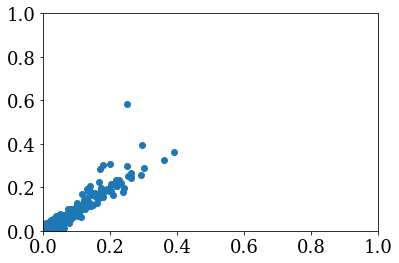

In [195]:
plt.scatter(mypreds4[0:1000],x_sigma_test[0:1000])
plt.xlim([0,1])
plt.ylim([0,1])

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


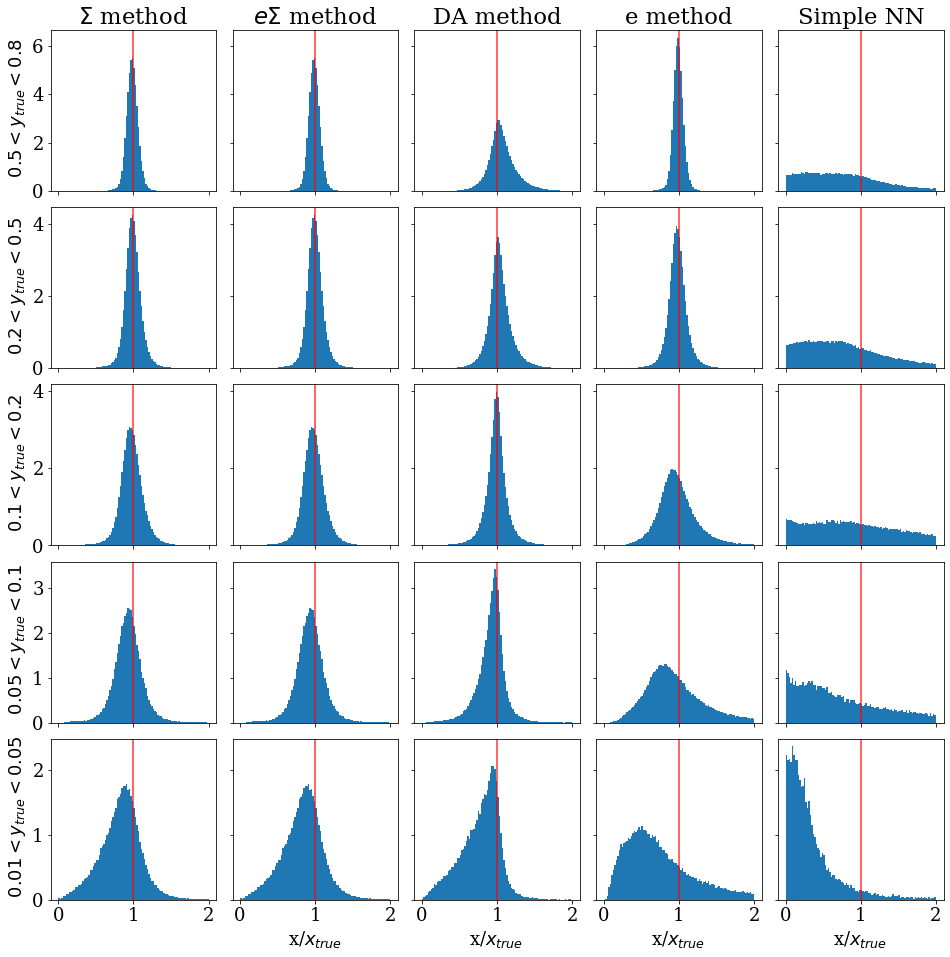

In [100]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 5*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0,2))

ax[4].hist(mypreds4[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[9].hist(mypreds4[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[14].hist(mypreds4[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[19].hist(mypreds4[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[24].hist(mypreds4[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()